**Impact of class imbalances comparing no means of balancing, dumping of samples of majority class and interpolation of samples for minority class**

In [8]:
# import libraries
import numpy as np
import pandas as pd
import plotly.express as px
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
import time

In [9]:
# visualize data
def visualize(immos):
  'visualize the immo data in an interactive 3D plot'
  garden = immos[immos.garden==True]
  no_garden = immos[immos.garden==False]

  fig = px.scatter_3d(immos, x="serviceCharge", y="yearConstructed", z="picturecount", color="garden", size_max=18, color_discrete_map={False:"blue", True:"orange"})
  fig.update_traces(marker=dict(size=3))
  fig.update_layout(autosize=False, width=800, height=500, scene=dict(
                      xaxis = dict(range=[0,500],),
                      yaxis = dict(range=[1850,2020],),
                      zaxis = dict(range=[0,30],)
                  ))
  fig.show()

In [10]:
# import apartment data
# already cleaned i.e. removal of NaN rows
immos = pd.read_csv("https://raw.githubusercontent.com/pejokoe/sumsem/master/sfml/immo_cleaned.csv")

# perform feature selection
x_new = SelectKBest(f_classif, k=3).fit_transform(immos.drop(columns=["garden"]), immos.garden)
# checking x_new lead to the conclusion that the columns serviceCharge, picturecount and yearConstructed have most impact

immos = immos[["serviceCharge", "yearConstructed", "picturecount", "garden"]].sample(10000)
print(immos.head())
# check for class imbalance
garden = immos[immos.garden==True]
no_garden = immos[immos.garden==False]
print(" immos garden: ", len(garden))
print(" immos no_garden: ", len(no_garden))
print("Imbalance: Minority class makes %.2f %% of all samples." % (len(garden)/(len(garden) + len(no_garden)) * 100))


        serviceCharge  yearConstructed  picturecount  garden
494             180.0           1960.0             5   False
55768           230.0           1985.0             9   False
1962            235.0           1972.0            16   False
102389          200.0           2016.0             9   False
6946            130.0           1938.0             6   False
 immos garden:  1933
 immos no_garden:  8067
Imbalance: Minority class makes 19.33 % of all samples.


In [11]:
# visualize on a randomly sampled subset to allow better visual interpretation
visualize(immos.sample(1000))

In [12]:
# # as imbalance is mild, artificially increase it to 90 % by dumping garden immos
# garden = garden.sample(int(len(no_garden) * 0.1))
# immos = pd.concat((garden, no_garden), axis=0)
# immos.reset_index(drop=True)

# # check again for class imbalance
# garden = immos[immos.garden==True]
# no_garden = immos[immos.garden==False]
# print("After artificial class imbalance increase:")
# print(" immos garden: ", len(garden))
# print(" immos no_garden: ", len(no_garden))

In [13]:
# # visualize after class imbalancing
# visualize(immos.sample(500))

In [14]:
# split data into training and test set and input and target
xTrain, xTest, yTrain, yTest = train_test_split(immos[["serviceCharge", "picturecount", "yearConstructed"]], immos["garden"], test_size = 0.1, shuffle=True, random_state=0)
print(xTrain[:5], yTrain[:5])

        serviceCharge  picturecount  yearConstructed
104393          160.0            19           1900.0
22651           100.0            14           1939.0
44553           184.0            16           1955.0
143266          150.0            11           2014.0
121013          102.0             8           1986.0 104393    False
22651      True
44553     False
143266    False
121013    False
Name: garden, dtype: bool


       serviceCharge  picturecount  yearConstructed  garden
13711      211.25866            17      1982.496536    True
2212       120.00000             8      1964.000000   False
9682       130.00000             7      1963.706005    True
1234       280.00000            16      1994.000000    True
7797       190.00000            15      1998.000000   False


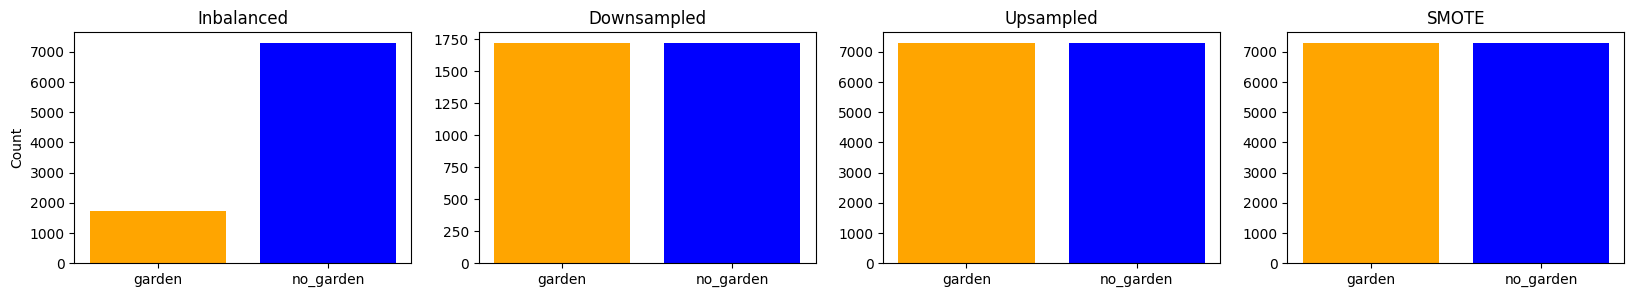

In [15]:
# balance classes 
# combine input and target for sampling
training_points = pd.concat((xTrain, yTrain), axis=1)
# data seperated by class
garden = training_points[training_points.garden==True]
no_garden = training_points[training_points.garden==False]
fig, axs = plt.subplots(1, 4)
fig.set_figheight(3)
fig.set_figwidth(20)

# method 0: use inbalanced training set without balancing measures
axs[0].bar(0.5, len(garden), color="orange", label="garden")
axs[0].bar(1.5, len(no_garden), color="blue", label="no_garden")
axs[0].set_title("Inbalanced")
axs[0].set_ylabel("Count")
axs[0].set_xticks([0.5, 1.5], ["garden", "no_garden"])

# method 1: discarding random sampels from majority class
no_garden_downsampling = no_garden.sample(len(garden))
tp_downsampling = pd.concat((garden, no_garden_downsampling), axis=0).sample(frac=1)
axs[1].bar(0.5, len(garden), color="orange", label="garden")
axs[1].bar(1.5, len(no_garden_downsampling), color="blue", label="no_garden")
axs[1].set_title("Downsampled")
axs[1].set_xticks([0.5, 1.5], ["garden", "no_garden"])

# method 3: upsampling duplicating random samples (multiple times)
garden_upsampling = resample(garden, replace=True, n_samples=len(no_garden))
tp_upsampling = pd.concat((garden_upsampling, no_garden), axis=0).sample(frac=1)
axs[2].bar(0.5, len(garden_upsampling), color="orange", label="garden")
axs[2].bar(1.5, len(no_garden), color="blue", label="no_garden")
axs[2].set_title("Upsampled")
axs[2].set_xticks([0.5, 1.5], ["garden", "no_garden"])

# method 4: Generate synthetic samples using SMOTE
smote = SMOTE(random_state=0)
x_smote, y_smote = (smote.fit_resample(training_points[["serviceCharge", "picturecount", "yearConstructed"]], training_points.garden))
tp_smote = pd.concat((x_smote, y_smote), axis=1).sample(frac=1)
print(tp_smote.head())
axs[3].bar(0.5, len(tp_smote[tp_smote.garden==True]), color="orange", label="garden")
axs[3].bar(1.5, len(tp_smote[tp_smote.garden==False]), color="blue", label="no_garden")
axs[3].set_title("SMOTE")
axs[3].set_xticks([0.5, 1.5], ["garden", "no_garden"])

In [16]:
# binarize function
def binarize(to_binarize):
  if to_binarize==False:
    return 0
  else:
    return 1

In [17]:
# scale all training inputs, binarize garden

# no measure
scaler_no_measure = MinMaxScaler()
x_no_measure = training_points[["serviceCharge", "picturecount", "yearConstructed"]]
x_no_measure = scaler_no_measure.fit_transform(x_no_measure)
y_no_measure = training_points["garden"].apply(binarize)

# downsampling
scaler_downsampling = MinMaxScaler()
x_downsampling = tp_downsampling[["serviceCharge", "picturecount", "yearConstructed"]]
x_downsampling = scaler_downsampling.fit_transform(x_downsampling)
y_downsampling = tp_downsampling["garden"].apply(binarize)

# upsampling
scaler_upsampling = MinMaxScaler()
x_upsampling = tp_upsampling[["serviceCharge", "picturecount", "yearConstructed"]]
x_upsampling = scaler_upsampling.fit_transform(x_upsampling)
y_upsampling = tp_upsampling["garden"].apply(binarize)

# smote
scaler_smote = MinMaxScaler()
x_smote = tp_smote[["serviceCharge", "picturecount", "yearConstructed"]]
x_smote = scaler_smote.fit_transform(x_smote)
y_smote = tp_smote["garden"].apply(binarize)

In [18]:
# first machine learning algorithm: SVM
# using rbf kernel as it is considered most powerful (default parameter)
svm_no_measure = SVC(class_weight="balanced")
svm_downsampling = SVC(class_weight="balanced")
svm_upsampling = SVC(class_weight="balanced")
svm_smote = SVC(class_weight="balanced")

times = [time.time()]
svm_no_measure = svm_no_measure.fit(x_no_measure, y_no_measure)
times.append(time.time())
svm_downsampling = svm_downsampling.fit(x_downsampling, y_downsampling)
times.append(time.time())
svm_upsampling = svm_upsampling.fit(x_upsampling, y_upsampling)
times.append(time.time())
svm_smote = svm_smote.fit(x_smote, y_smote)
times.append(time.time())

In [19]:
print("SVM no measure training time: %f s" % (times[1] - times[0]))
print("SVM downsampled training time: %f s" % (times[2] - times[1]))
print("SVM upsampled training time: %f s" % (times[3] - times[2]))
print("SVM smote training time: %f s" % (times[4] - times[3]))

SVM no measure training time: 3.292698 s
SVM downsampled training time: 0.352125 s
SVM upsampled training time: 7.218867 s
SVM smote training time: 6.980444 s


In [20]:
# compare results using precision, recall and confusion matrix
# scale test set with corresponding scaler
xTest_no_measure = scaler_no_measure.transform(xTest)
xTest_downsampling = scaler_downsampling.transform(xTest)
xTest_upsampling = scaler_upsampling.transform(xTest)
xTest_smote = scaler_smote.transform(xTest)
# use corresponding svm to predict
yPred_no_measure = svm_no_measure.predict(xTest_no_measure)
yPred_downsampling = svm_downsampling.predict(xTest_downsampling)
yPred_upsampling = svm_upsampling.predict(xTest_upsampling)
yPred_smote = svm_smote.predict(xTest_smote)

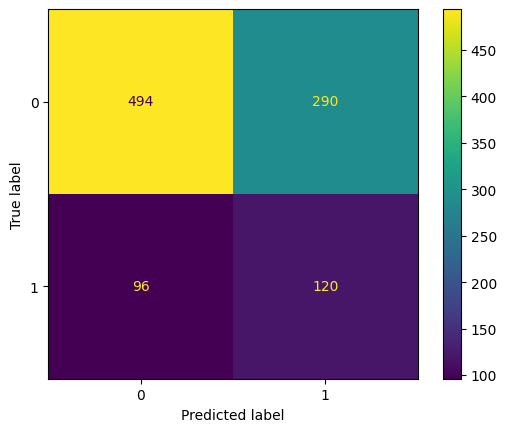

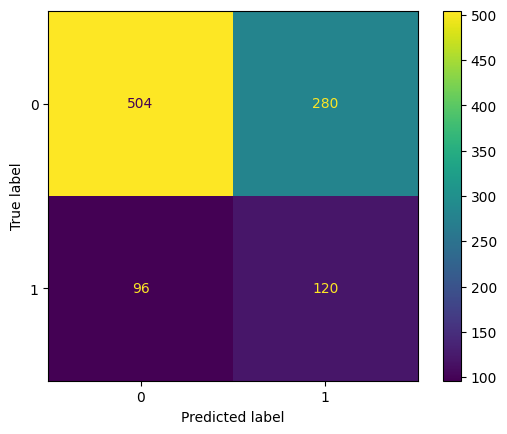

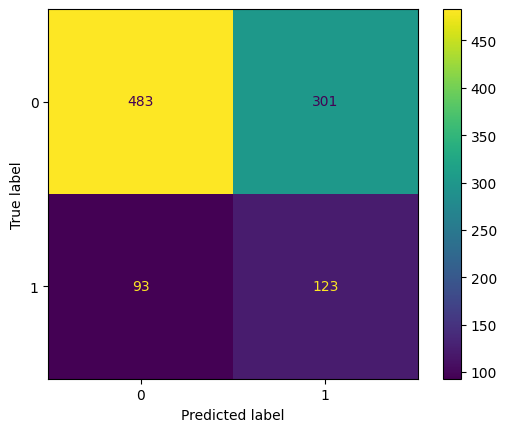

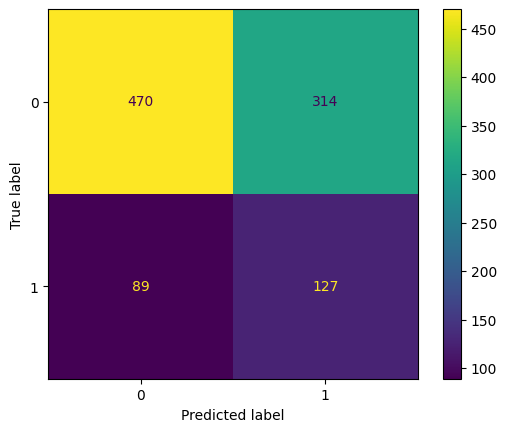

In [21]:
yTest = yTest.apply(binarize)
# confusion matrices
cm_no_measure = confusion_matrix(yTest, yPred_no_measure)
ConfusionMatrixDisplay(cm_no_measure).plot()

cm_downsampling = confusion_matrix(yTest, yPred_downsampling)
ConfusionMatrixDisplay(cm_downsampling).plot()

cm_upsampling = confusion_matrix(yTest, yPred_upsampling)
ConfusionMatrixDisplay(cm_upsampling).plot()

cm_smote = confusion_matrix(yTest, yPred_smote)
ConfusionMatrixDisplay(cm_smote).plot()


In [22]:
# precision and recall
# 